In [1]:
!pwd

/home/jupyter/NamikawaLab2019/DCGAN-TF2.0


In [2]:
%load_ext tensorboard

In [3]:
!rm -rf ./logs/

In [4]:
!pip install -q imageio --user
!pip install -q tqdm --user

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.0.0


In [7]:
import datetime
import glob
import os
import random
import time
from pathlib import Path

import imageio
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tqdm import tqdm

In [8]:
color_channel = 3
BATCH_SIZE = 256
EPOCHS = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE
noise_dim = 100
num_examples_to_generate = 16

now = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

data_root = Path('/mnt/dataset/wabisabi')
checkpoints_dir = './checkpoints'
epochs_dir = './epochs'
gifs_dir = './gifs'

In [9]:
!mkdir -p $checkpoints_dir
!mkdir -p $epochs_dir
!mkdir -p $gifs_dir

In [10]:
(mnist_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
print('MNIST Images Shape: {}'.format(mnist_images.shape))
mnist_images = mnist_images.reshape(mnist_images.shape[0], 28, 28, 1).astype('float32')
mnist_images = (mnist_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_images).shuffle(len(mnist_images)).batch(BATCH_SIZE)
print('MNIST Dataset: {}'.format(mnist_dataset))

MNIST Images Shape: (60000, 28, 28)
MNIST Dataset: <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [11]:
all_image_paths = [str(path) for path in list(data_root.iterdir())]
all_image_count = len(all_image_paths)
print('All Image Count: {}'.format(all_image_count))

All Image Count: 13415


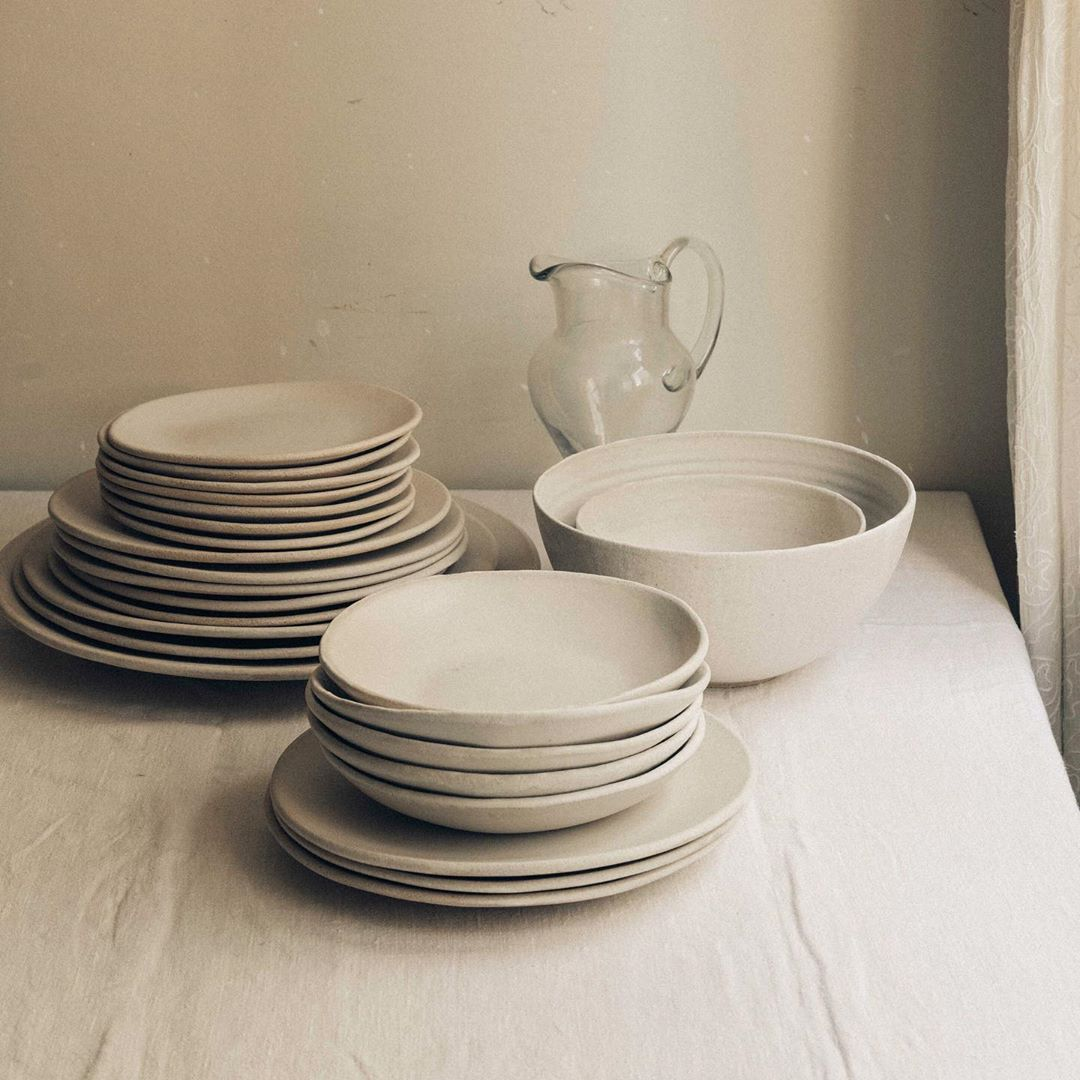

In [12]:
# Sampling Check
sample_image_path = random.choice(all_image_paths)
display.display(display.Image(sample_image_path))

In [13]:
sample_image_raw = tf.io.read_file(sample_image_path)
print('Sample Image Raw: {} ...'.format(repr(sample_image_raw)[:100]))

sample_image_tensor = tf.image.decode_jpeg(sample_image_raw, channels=3)
print('Sample Image Tensor: {}'.format(sample_image_tensor))
print('Sample Image Tensor Type: {}, Shape: {}, DataType: {}'.format(type(sample_image_tensor), sample_image_tensor.shape, sample_image_tensor.dtype))

Sample Image Raw: <tf.Tensor: id=13, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\ ...
Sample Image Tensor: [[[167 144 113]
  [167 144 113]
  [161 138 107]
  ...
  [207 188 158]
  [211 191 164]
  [215 195 168]]

 [[164 141 110]
  [168 145 114]
  [165 142 111]
  ...
  [203 184 154]
  [206 186 159]
  [210 190 163]]

 [[161 138 107]
  [169 146 115]
  [169 146 115]
  ...
  [203 184 154]
  [205 185 158]
  [209 189 162]]

 ...

 [[187 175 151]
  [189 177 153]
  [193 181 157]
  ...
  [228 227 223]
  [227 226 222]
  [227 226 222]]

 [[185 173 149]
  [185 173 149]
  [188 176 152]
  ...
  [231 230 226]
  [227 226 222]
  [223 222 218]]

 [[190 178 154]
  [185 173 149]
  [182 170 146]
  ...
  [234 233 229]
  [228 227 223]
  [220 219 215]]]
Sample Image Tensor Type: <class 'tensorflow.python.framework.ops.EagerTensor'>, Shape: (1080, 1080, 3), DataType: <dtype: 'uint8'>


In [14]:
sample_image_final = tf.image.resize(sample_image_tensor, [28, 28])
sample_image_final = (sample_image_final - 127.5) / 127.5  # Normalize the image to [-1, 1]
print('Sample Image Final: {}'.format(sample_image_final))
print('Sample Image Final Type: {}, Shape: {}, DataType: {}'.format(type(sample_image_final), sample_image_final.shape, sample_image_final.dtype))

Sample Image Final: [[[ 0.29579827  0.13109238 -0.11204481]
  [ 0.32773113  0.16302526 -0.080112  ]
  [ 0.33077225  0.16606636 -0.07707094]
  ...
  [-0.27278945 -0.31984827 -0.4139659 ]
  [ 0.05306205 -0.08811448 -0.25057906]
  [ 0.6737475   0.587473    0.44629648]]

 [[ 0.29799923  0.11760709 -0.12553017]
  [ 0.33501384  0.15462168 -0.08851558]
  [ 0.35190058  0.17150843 -0.07162882]
  ...
  [-0.28183216 -0.34457725 -0.4308518 ]
  [ 0.44806015  0.32256997  0.12649153]
  [ 0.68519443  0.5877143   0.49191546]]

 [[ 0.35138047  0.17098832 -0.07214888]
  [ 0.3186472   0.13825504 -0.10488221]
  [ 0.384754    0.20436186 -0.0387754 ]
  ...
  [-0.3042812  -0.36590588 -0.453861  ]
  [ 0.5852756   0.4847953   0.32757294]
  [ 0.7051249   0.6163688   0.45514324]]

 ...

 [[ 0.5148076   0.42068997  0.23245467]
  [ 0.42697024  0.3328526   0.1446173 ]
  [ 0.4910343   0.39691666  0.20868136]
  ...
  [ 0.76862985  0.7607867   0.72941417]
  [ 0.7875135   0.77967036  0.7482978 ]
  [ 0.79908186  0.791238

Text(0.5, 1.0, 'sample_image_final')

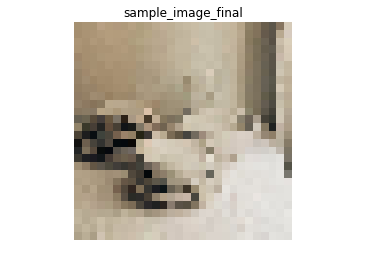

In [15]:
plt.imshow((sample_image_final + 1) / 2)  # for 'Clipping input data to the valid range for imshow with RGB data [0..1] for floats'
plt.grid(False)
plt.axis('off')
plt.xlabel(sample_image_path)
plt.title('sample_image_final')

In [16]:
def load_and_preprocess_image(path):
    raw = tf.io.read_file(path)
    tensor = tf.image.decode_jpeg(raw, channels=3)
    resized = tf.image.resize(tensor, [28, 28])
    preprocessed = (resized - 127.5) / 127.5
    
    return preprocessed

In [17]:
path_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
train_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=all_image_count).batch(BATCH_SIZE)
print('Train Dataset: {}'.format(train_dataset))

Train Dataset: <BatchDataset shapes: (None, 28, 28, 3), types: tf.float32>


In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(color_channel, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, color_channel)

    return model

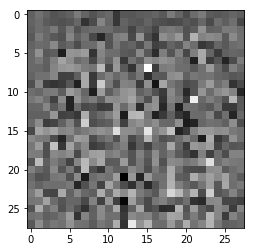

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, color_channel]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print('Decision: {}'.format(decision))

Decision: [[-0.00034432]]


In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(epochs_dir + '/image_{}_epoch_{:04d}.png'.format(now, epoch))
  plt.show()

In [30]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

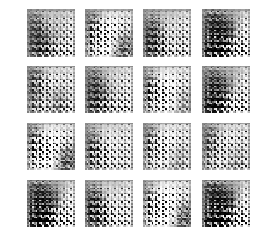

Time for epoch 6 is 116.05089592933655 sec
Image Batch: [[[[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
 

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open(epochs_dir + '/image_{}_epoch_{:04d}.png'.format(now, epoch_no))

In [ ]:
anim_file = gifs_dir + '/dcgan_{}.gif'.format(now)

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(epochs_dir + '/image_{}_*.png'.format(now))
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2 * (i ** 0.5)
    if round(last) < round(frame):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

  display.Image(filename=anim_file)